<a href="https://colab.research.google.com/github/sarahshahrir/micrograd_from_scratch/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Simple examples for intuitions

1. Implement a simple function

In [100]:
def f(x):
    return 3*x**2 - 4*x + 5
f(3.0)

20.0

2. Plot the function

*   *Note:* `np.arange(start, stop, step)` values are generated within the half-open interval [start, stop), with spacing between values given by step.

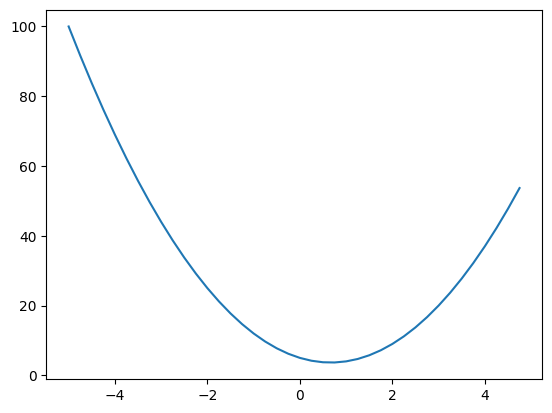

In [101]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs) # apply values of x's to get the y's of the function
plt.plot(xs,ys)

3. Observe slope of function
* `(f(x + h) - f(x))/h`
: tells us how fast the function is changing (slope) in range x until x+h

In [102]:
h = 0.001
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

# More complex examples

In [103]:
h = 0.0001

# inputs
a = 2.0
b = -1.0
c = 10.0

d1 = a*b + c
a += h # bump the value a by h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 8.0
d2 7.9999
slope -0.9999999999976694


Think intuitively:
- Notice in the above example, `b` is negative and we bump up `a` by a positive value.
- This means that less value is added to `d2`.
- So, value of `d2` gets smaller.

How did we come to conclusion that the above function approximates the derivative of expression `d = a*b +c` wrt to `a`?
- You are checking how sensitive `d` is to changes in `a`, which is exactly the derivative of `d` wrt to `a` measures.
- If we do `b += h` or `c += h`, that means we are measuring derivative of `d` wrt to `b` and `c` respectively.


# Let's start building

**Build value object**
* We need some data structures to maintain the massive expressions in neural
networks
* We would also like to run backpropagation, where we will start at the end (*refer: visualizations from graphiz*) and reverse and calculate the gradient along all the intermediate values.
* What the above statement does is actually compute derivative of each node wrt `L`
* We do this because in neural network, we are interested in the Loss function `L` wrt to weights of a neural network
* It helps to know how the weights of the nodes are impacting the Loss function

In [184]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.label = label

    # we need to keep track of what values produce other values
    self._prev = set(_children)

    # we want to know how the curr value is produced from the prev value
    self._op = _op

    # var that maintains the derivative of L wrt to that value
    self.grad = 0.0

    # chains the output gradient with input gradient
    # assuming its a leaf node, theres nothing to do
    self._backward = lambda: None

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __truediv__(self, other):
    # a / b = a * b^-1
    return self * other**-1

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def tanh(self):
    # Implement activation function (tanh)
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # out.data bcs math.exp(x) is in out var
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supportiung int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    # Call ._backward on all the nodes in a topological order
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self) # start from root node o to all its children

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [132]:
a = Value(2.0)
b = Value(3.0)
a - b

Value(data=-1.0)

**Observe this activation function (*tanh*):**
* The inputs gets squashed at the y-axis
* Right at 0, we get 0
* As the input gets more positive, function will only go up to 1
* Very positive inputs will be capped smoothly at 1
* Very negative input will be capped smoothly at -1

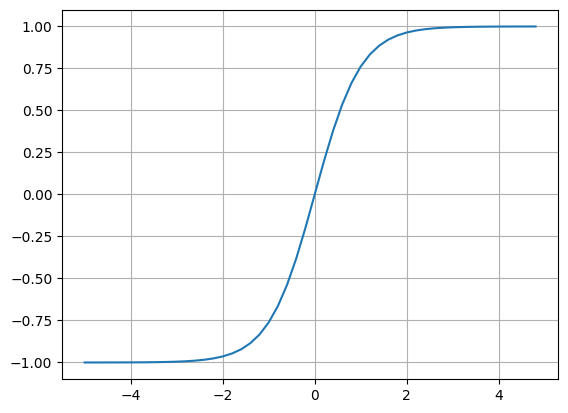

In [105]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

**Visualize the expression graph with graphviz**
* This visualizes the forward pass


In [106]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

**Ensuring that the backward function finds grad accurately when a node i used twice**
* Use '+=' for grad in Value object

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
a  = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

# **Example**: A Neuron

* manually assigning its gradient with chain rule

In [152]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*x1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ---- breaking up a tanh --
e = (2*n).exp()
o = (e - 1) / (e + 1)
# --------------------------
o.label = 'o'

In [133]:
o.grad = 1.0

n.grad = 0.5

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [153]:
o.backward()

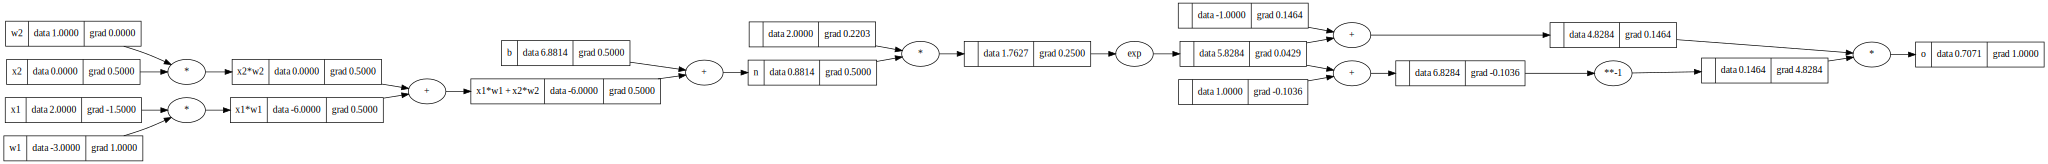

In [154]:
draw_dot(o)

# Doing the same thing but in PyTorch

In [155]:
import torch

* Type cast elements to be double() because Python uses double precision for float by default, but Tensors are in single precision float
* by default PyTorch assumes these leaf nodes don't require gradient, need to explicitly say `requires_grad = True`

In [158]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [161]:
x2.grad.item()

0.5000001283844369

In [162]:
o.data.item()

0.7071066904050358

# Building out a neurel network library

In [227]:
import random

class Neuron:
  def __init__(self, nin): # nin = num of inputs
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    # zip takes two iterators, takes new iterator that iterates over the tuples, and their corresponding entries
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # sum adds first param on top of second param
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # return [p for neuron in self.neurons for p in neuron.parameters()]
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.10889569328079414)

In [ ]:
draw_dot(n(x))

Small dataset

In [230]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets for the corresponding array in xs

**Three main steps in neural network**
* STEP 1: Forward Pass
* STEP 2: Backward Pass
* STEP 3: Update, reiterate STEP 1

In [ ]:
# apply MSE
# ygt is y-ground truth
for k in range(20):
  # 1. FORWARD PASS
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))

  # 2. BACKWARD PASS
  for p in n.parameters():
    # always forgotten
    # reset all grad bcs prev grad are based on prev data, but we updated the data/w/b
    p.grad = 0.0
  loss.backward()

  # 3. UPDATE
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

The weights and biases that makes our NN predict the desired targets very very close

In [ ]:
n.parameters()